# Multi-echelon Supply Chain Optimization Using Deep Reinforcement Learning

This prototype demonstrates how multi-echelon supply chain control policies can be optimized using deep reinforcement learning methods.

### Use Case
We assume a multi-echelon supply chain (e.g. central factory and warehouses) that serves stochastic tyme-varying demand. The economic model of the chain includes storage and transportation costs, capacity constraints, and other complexities. Our goal is to learn optimal policy that controls replenishment and transportation decisions balancing various costs and stock-out risks/losses.

### Prototype: Approach and Data
We first create a basic environment simulator with a factory and several warehouses. We then assume that each node is controlled using the standard `(s,Q)` policy, and optimize policy parameters using conventional methods such as Bayesian search. Finally, we show how the production and replenishment policy can be implemented using reinforcement learning.

### Usage and Productization
The prototype can be used to optimize basic supply chains. The reinforcement learning solution is provided mainly for educational purpose because of its instability and high computational complexity.

## References
1. Kemmer L., et al. -- Reinforcement learning for supply chain optimization, 2018

In [2]:
#
# Imports and settings
#
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.display import display
import collections

#from qbstyles import mpl_style

#mpl_style(dark=False)

In [8]:
!pip install ax-platform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.5 MB/s eta 0:00:00


# Defining the Supply Chain Environment

In [3]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    def stock_levels(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock) )

class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # episode duration
        self.warehouse_num = 3
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units

        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        self.penalty_unit_cost = self.unit_price

        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)

        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0])
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1


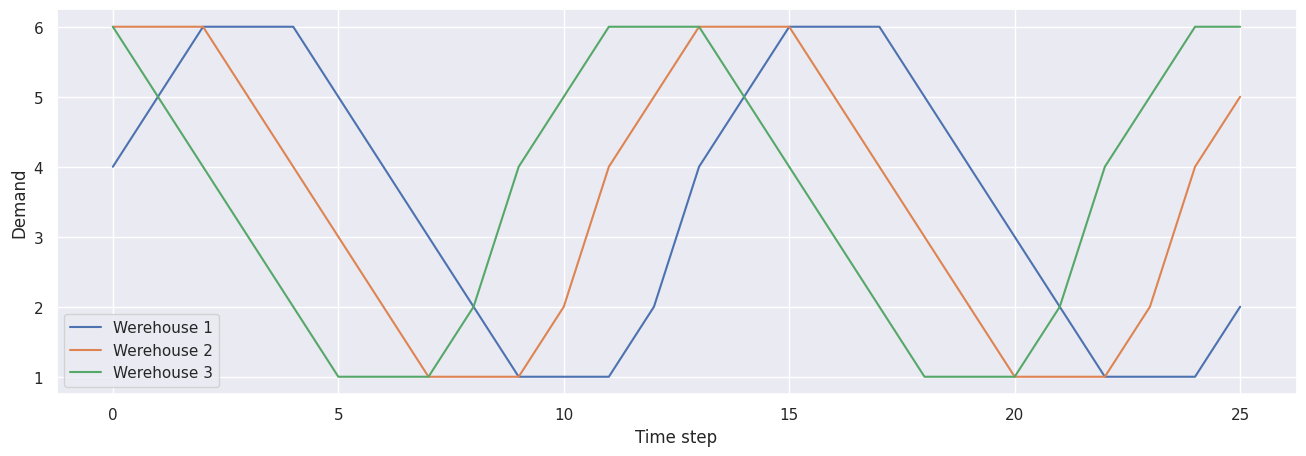

In [4]:
# visualize demand functions for warehouses
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)
plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Werehouse {i+1}' for i in range(env.warehouse_num)])

# Common Functions and Visualization

In [5]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)

    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)

    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

# Baseline Policy - (s,Q)

In [6]:
# We use (s, Q)-policy as a baseline
# The policy is: Order your Economic Order Quantity Q, every time your inventory
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]

        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock:
            action.production_level = self.factory_reorder_amount
        else:
            action.production_level = 0
        return action

def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

### Optimizing (s, Q)-policy parameters using Facebook Ax

In [9]:
from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'],
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=200,
    )

[INFO 10-24 13:21:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-24 13:21:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-24 13:21:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-24 13:21:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

In [10]:
display(best_parameters)
display(best_values)

{'factory_s': 0.0,
 'factory_Q': 18.513752861914323,
 'w1_s': 12.955078733500681,
 'w1_Q': 7.009949102653113,
 'w2_s': 2.624487521771613,
 'w2_Q': 8.955235942390802,
 'w3_s': 3.4088533373979377,
 'w3_Q': 7.6657082146709765}

({'objective': 4559.371902454621},
 {'objective': {'objective': 99386.95918754819}})

Reward: mean 7166.17, standard deviation 675.8583735517375


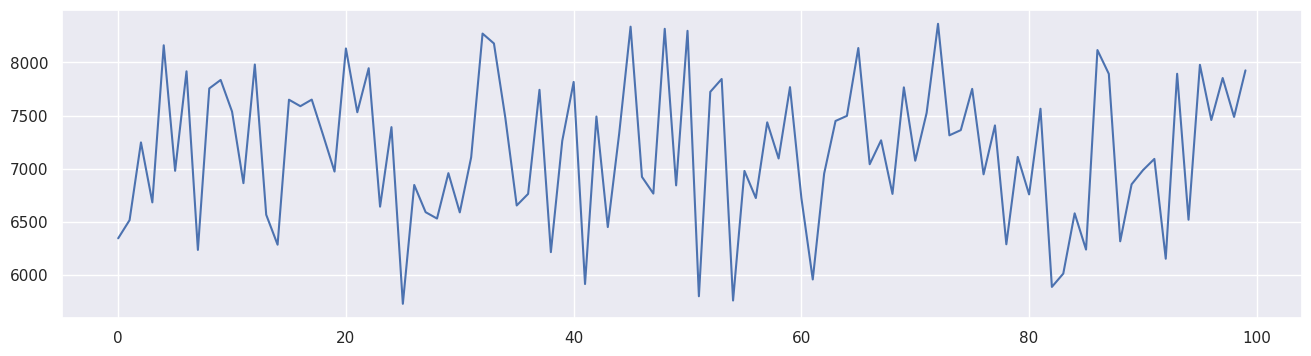

In [11]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 7494.0


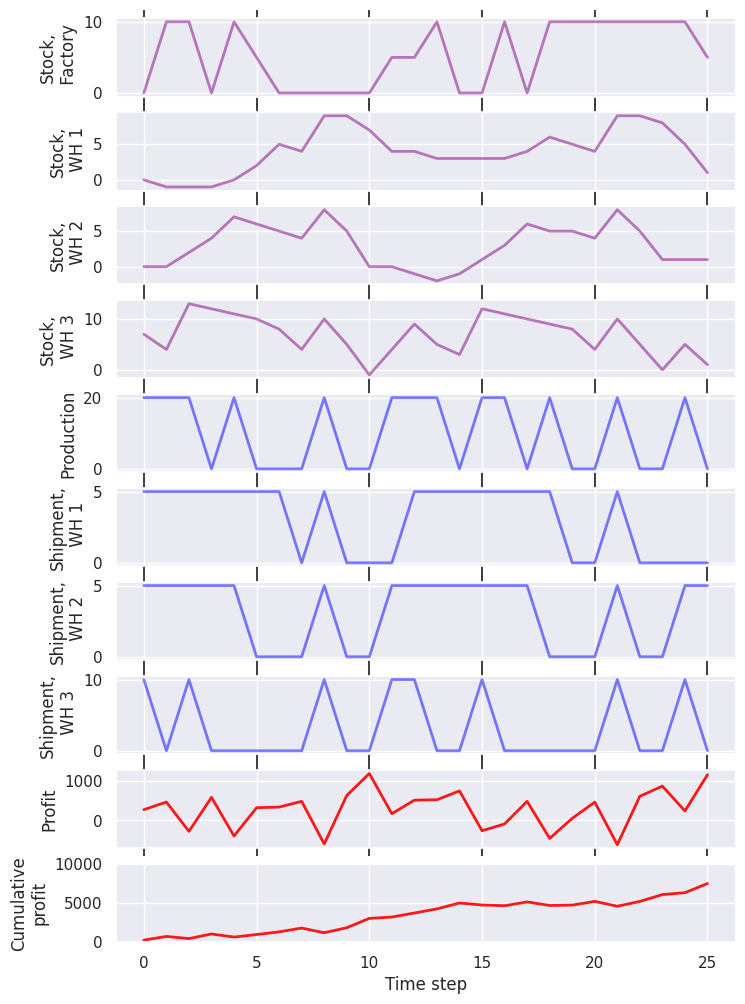

In [12]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

### Optimization of (s, Q)-policy parameters using brute force search

In [13]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1,
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -147069.5
Configuration #100 -- -146164.8
Configuration #200 -- -146164.8
Configuration #300 -- -146164.8
Configuration #400 -- -146164.8
Configuration #500 -- -146164.8
Configuration #600 -- -146164.8
Configuration #700 -- -146164.8
Configuration #800 -- -135251.9
Configuration #900 -- -135251.9
Configuration #1000 -- -135251.9
Configuration #1100 -- -135251.9
Configuration #1200 -- -135251.9
Configuration #1300 -- -135251.9
Configuration #1400 -- -135251.9
Configuration #1500 -- -135251.9
Configuration #1600 -- -135251.9
Configuration #1700 -- -135251.9
Configuration #1800 -- -135251.9
Configuration #1900 -- -135251.9
Configuration #2000 -- -135251.9
Configuration #2100 -- -135251.9
Configuration #2200 -- -3045.5
Configuration #2300 -- -2993.4
Configuration #2400 -- -2993.4
Configuration #2500 -- -2993.4
Configuration #2600 -- -2993.4
Configuration #2700 -- -2993.4
Configuration #2800 -- -2993.4
Configuration #2900 -- -2993.4
Configuration #3000 -- -1670.1
Configu

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [15]:
!pip install ray[rllib]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 8.9 MB/s eta 0:00:00


In [17]:
import gym
from gym.spaces import Box
import ray
from ray.rllib.utils import try_import_tf
import ray.rllib.algorithms.sac as sac
from ray.tune.logger import pretty_print

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
!pip install gymnasium


In [28]:
import numpy as np
import gymnasium as gym  # Updated to gymnasium
from gymnasium.spaces import Box  # Import from gymnasium.spaces

# Define your custom environment for the supply chain problem
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        # Define action space as a continuous space with Box type
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1,), dtype=np.float32)
        # Define observation space based on the state space dimensions
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()),), dtype=np.float32)

    def reset(self, seed=None, options=None):
        # Initialize the supply chain environment and state
        self.supply_chain = SupplyChainEnvironment()  # Assume this is implemented elsewhere
        self.state = self.supply_chain.initial_state()

        # Return the state and an empty info dictionary
        return self.state.to_array(), {}

    def step(self, action):
        # Create action object
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]

        # Perform the environment step
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, False,{}

# The rest of the code remains the same for SACConfig and training
# Initialize Ray
ray.shutdown()
ray.init()

# Use the updated SACConfig approach for building and training the SAC algorithm
def train_sac_with_config():
    # Create the SACConfig object and configure it for your environment
    config = (
        SACConfig()
        .environment(SimpleSupplyChain)  # Use your custom environment here
        .training(
            gamma=0.9,
            actor_lr=0.001,            # Learning rate for the actor network
            critic_lr=0.002,           # Learning rate for the critic network
            train_batch_size=32,        # Batch size for training
        )
        .resources(num_gpus=0)  # Assuming you're not using a GPU; change if needed
    )

    # Build the SAC algorithm object from the configuration
    algo = config.build()

    # Train for a few iterations (or as many as required)
    for i in range(200):  # Run 200 iterations, adjust as needed
        result = algo.train()
        print(f"Iteration {i}:")
        print(result)
# Run the training process
train_sac_with_config()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-10-24 14:20:26,050	INFO worker.py:1816 -- Started a local Ray instance.
2024-10-24 14:20:27,990	WARNING sac.py:489 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:568: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. 

Iteration 0:
{'timers': {'env_runner_sampling_timer': 0.00740262673269992, 'replay_buffer_add_data_timer': 0.054432439585486554, 'training_iteration_time_sec': 1.0896663665771484, 'restore_workers_time_sec': 2.2745132446289064e-05, 'training_step_time_sec': 0.007035398483276367}, 'env_runners': {'num_episodes': 1, 'num_agent_steps_sampled_lifetime': {'default_agent': 5050}, 'num_module_steps_sampled_lifetime': {'default_policy': 5050}, 'num_module_steps_sampled': {'default_policy': 1}, 'num_env_steps_sampled_lifetime': 5050, 'sample': 0.008816351051099725, 'num_env_steps_sampled': 1, 'num_agent_steps_sampled': {'default_agent': 1}, 'time_between_sampling': 0.1124119017893262, 'episode_return_min': -764710.1860622168, 'episode_return_max': -612900.519395113, 'episode_len_min': 25, 'episode_len_mean': 25.0, 'episode_len_max': 25, 'agent_episode_returns_mean': {'default_agent': -731727.8821202744}, 'episode_duration_sec_mean': 0.0019382202000633698, 'episode_return_mean': -731727.88212027

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from ray.rllib.algorithms.sac import SACConfig

def train_sac_with_visualization():
    # Create the SACConfig object and configure it for your environment
    config = (
        SACConfig()
        .environment(SimpleSupplyChain)  # Use your custom environment here
        .training(
            gamma=0.9,
            actor_lr=0.001,            # Learning rate for the actor network
            critic_lr=0.002,           # Learning rate for the critic network
            train_batch_size=32,        # Batch size for training
        )
        .resources(num_gpus=0)  # Assuming you're not using a GPU; change if needed
    )

    # Build the SAC algorithm object from the configuration
    algo = config.build()

    # Lists to store results for visualizations
    rewards = []
    actor_losses = []
    critic_losses = []
    entropy_values = []

    # Train for a few iterations
    for i in range(1):  # Run 200 iterations, adjust as needed
        result = algo.train()

    print(result)  # Print the entire result dictionary
train_sac_with_visualization()


2024-10-24 15:34:02,573	WARNING sac.py:489 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2024-10-24 15:34:03,540	WARNING sac.py:489 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2024-10-24 15:34:03,560	WARNING util.py:61 -- Install gputil for GPU system monitoring.


{'timers': {'env_runner_sampling_timer': 0.00533452477665102, 'replay_buffer_add_data_timer': 0.0011872026216436158, 'training_iteration_time_sec': 1.0034005641937256, 'restore_workers_time_sec': 3.2329559326171874e-05, 'training_step_time_sec': 0.01040356159210205}, 'env_runners': {'num_episodes': 0, 'num_agent_steps_sampled_lifetime': {'default_agent': 5995}, 'num_module_steps_sampled_lifetime': {'default_policy': 5995}, 'num_module_steps_sampled': {'default_policy': 1}, 'num_env_steps_sampled_lifetime': 5995, 'sample': 0.004379573967480907, 'num_env_steps_sampled': 1, 'num_agent_steps_sampled': {'default_agent': 1}, 'time_between_sampling': 0.003416450082736427, 'episode_return_min': -582450.8114444017, 'episode_return_max': -457329.32119619846, 'episode_len_min': 25, 'episode_len_mean': 25.0, 'episode_len_max': 25, 'agent_episode_returns_mean': {'default_agent': -489183.12530132534}, 'episode_duration_sec_mean': 0.0008524211996700614, 'episode_return_mean': -489183.12530132534, 'mo

# **Custom SAC Implementation**

In [55]:
import gym
from gym.spaces import Box
import numpy as np

class SimpleSupplyChain1(gym.Env):
    def __init__(self, config=None):
        super(SimpleSupplyChain1, self).__init__()

        # Supply chain parameters
        self.config = config or {}
        self.warehouse_num = self.config.get('warehouse_num', 3)  # Number of warehouses (customizable)
        self.max_production = self.config.get('max_production', 20.0)  # Maximum production level
        self.state_dim = self.config.get('state_dim', self.warehouse_num + 2)  # Example state dimension

        # Define action space: [production_level, shipping_to_warehouse1, shipping_to_warehouse2, ...]
        self.action_space = Box(low=0.0, high=self.max_production, shape=(self.warehouse_num + 1,), dtype=np.float32)

        # Define observation space (assuming continuous variables for state like inventory levels, demand, etc.)
        self.observation_space = Box(low=-10000, high=10000, shape=(self.state_dim,), dtype=np.float32)

        # Initialize environment variables
        self.state = None
        self.done = False

    def reset(self, seed=None, options=None):
        # Reset the state of the supply chain (e.g., set initial inventories and demands)
        if seed is not None:
            np.random.seed(seed)

        # For simplicity, let's assume the state consists of:
        # [current_demand, current_production_level, inventory_levels at each warehouse]
        initial_demand = np.random.uniform(50, 100)  # Example demand
        initial_production = 0.0  # Start with no production
        initial_inventory = np.random.uniform(10, 50, size=self.warehouse_num)  # Random initial inventories

        self.state = np.concatenate([[initial_demand, initial_production], initial_inventory])
        self.done = False

        # Return the initial state and an empty info dictionary
        return self.state, {}

    def step(self, action):
        # Unpack action: [production_level, shipping_to_warehouse1, shipping_to_warehouse2, ...]
        production_level = action[0]
        shipping_to_warehouses = action[1:]

        # Example state update logic:
        # 1. Calculate new demand (simplified as a random fluctuation for now)
        demand_change = np.random.uniform(-5, 5)
        new_demand = self.state[0] + demand_change

        # 2. Update inventory levels based on shipping and production
        new_inventory = self.state[2:] + production_level - shipping_to_warehouses

        # 3. Production and shipping costs could be incorporated into the reward
        production_cost = production_level * 2  # Example cost per unit production
        shipping_cost = np.sum(shipping_to_warehouses) * 0.5  # Example cost per unit shipped
        reward = - (production_cost + shipping_cost)  # Negative cost (penalty) as reward

        # 4. Determine if the episode is done (e.g., based on some criteria like inventory depletion)
        if np.any(new_inventory < 0):  # If any warehouse runs out of stock, terminate the episode
            self.done = True
            reward -= 100  # Add a large penalty for depleting stock

        # Update the state
        self.state = np.concatenate([[new_demand, production_level], new_inventory])

        # Return the new state, reward, done flag, and empty info
        return self.state, reward, self.done, {}

    def render(self, mode='human'):
        # You can implement this to visually display the environment state (optional)
        pass

    def close(self):
        # Any cleanup if needed (optional)
        pass


In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import matplotlib.pyplot as plt
import random


In [57]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = torch.relu(self.layer1(state))
        a = torch.relu(self.layer2(a))
        return self.max_action * torch.tanh(self.layer3(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.relu(self.layer1(torch.cat([state, action], 1)))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


In [58]:
class SACAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_2 = Critic(state_dim, action_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=3e-4)
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=3e-4)

        self.replay_buffer = deque(maxlen=1000000)

    def select_action(self, state):
        #state = torch.FloatTensor(state).to(device)
        state = torch.FloatTensor(state).reshape(1, -1).to(device)
        return self.actor(state).detach().cpu().numpy()

    def store_transition(self, transition):
        self.replay_buffer.append(transition)

    def train(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return

        # Sample a batch from the replay buffer
        batch = np.array(random.sample(self.replay_buffer, batch_size))
        states = torch.FloatTensor(np.vstack(batch[:, 0])).to(device)
        actions = torch.FloatTensor(np.vstack(batch[:, 1])).to(device)
        rewards = torch.FloatTensor(np.vstack(batch[:, 2])).to(device)
        next_states = torch.FloatTensor(np.vstack(batch[:, 3])).to(device)
        dones = torch.FloatTensor(np.vstack(batch[:, 4])).to(device)

        # Train the critics
        target_actions = self.actor(next_states)
        target_q1 = self.critic_1(next_states, target_actions)
        target_q2 = self.critic_2(next_states, target_actions)
        target_q = rewards + (1 - dones) * 0.99 * torch.min(target_q1, target_q2)

        current_q1 = self.critic_1(states, actions)
        current_q2 = self.critic_2(states, actions)

        critic_1_loss = nn.MSELoss()(current_q1, target_q.detach())
        critic_2_loss = nn.MSELoss()(current_q2, target_q.detach())

        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()

        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # Train the actor
        actor_loss = -self.critic_1(states, self.actor(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return critic_1_loss.item(), critic_2_loss.item(), actor_loss.item()


In [59]:
def train_agent(env, agent, episodes=5):
    rewards = []
    critic_losses = []
    actor_losses = []

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition((state, action, reward, next_state, float(done)))

            # Train the agent
            critic_loss_1, critic_loss_2, actor_loss = agent.train()
            critic_losses.append((critic_loss_1, critic_loss_2))
            actor_losses.append(actor_loss)

            state = next_state
            episode_reward += reward

        rewards.append(episode_reward)
        print(f"Episode: {episode}, Reward: {episode_reward}, Critic Loss: {np.mean(critic_losses[-1])}, Actor Loss: {actor_losses[-1]}")

    return rewards, critic_losses, actor_losses


In [60]:
if __name__ == "__main__":
    env = SimpleSupplyChain1()  # Provide any necessary configuration here
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = env.action_space.high[0]

    # Initialize the SAC agent
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sac_agent = SACAgent(state_dim, action_dim, max_action)

    # Train the agent
    rewards, critic_losses, actor_losses = train_agent(env, sac_agent, episodes=1)

    # Plotting the results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(1, 2, 2)
    plt.plot(actor_losses, label='Actor Loss')
    plt.plot(np.array(critic_losses)[:, 0], label='Critic 1 Loss')
    plt.plot(np.array(critic_losses)[:, 1], label='Critic 2 Loss')
    plt.title('Losses over Episodes')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


ValueError: expected sequence of length 5 at dim 1 (got 0)

In [ ]:

if __name__ == "__main__":
    # Create the environment
    env = gym.make('YourSupplyChainEnv')  # Replace with your supply chain environment
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = env.action_space.high[0]

    # Initialize the agent
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sac_agent = SACAgent(state_dim, action_dim, max_action)

    # Train the agent
    rewards, critic_losses, actor_losses = train_agent(env, sac_agent, episodes=1000)

    # Plotting the results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(1, 2, 2)
    plt.plot(actor_losses, label='Actor Loss')
    plt.plot(np.array(critic_losses)[:, 0], label='Critic 1 Loss')
    plt.plot(np.array(critic_losses)[:, 1], label='Critic 2 Loss')
    plt.title('Losses over Episodes')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}

ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512]
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000

    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(200):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

train_ddpg()

ModuleNotFoundError: No module named 'gym'

# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = "/content/output_file [SAC].json"
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] )
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

Return is 9238.567217886448


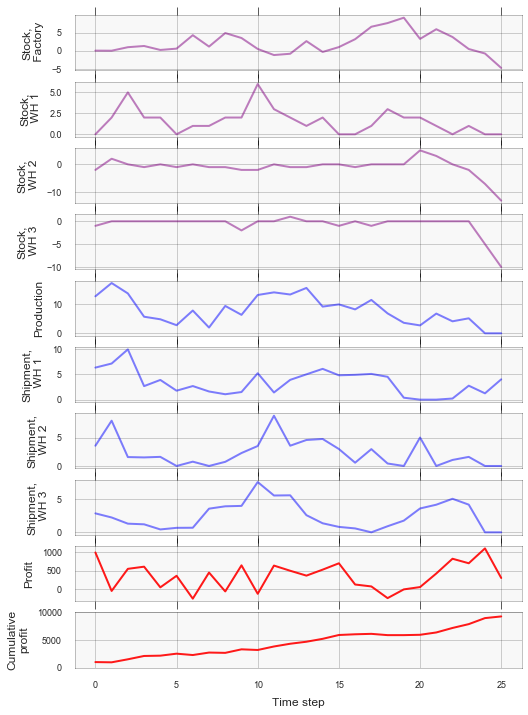

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))